# TF-IDF + Logistic Regression Baseline

**Approach**: Traditional ML with TF-IDF features

This is an interpretable baseline:
1. Extract TF-IDF features from job titles (word importance)
2. Train Logistic Regression classifiers
3. Analyze feature importance (which words matter most)
4. Compare with Random Forest for robustness

**Advantages**:
- ✅ Highly interpretable (can see important words)
- ✅ Fast training and inference
- ✅ Small model size
- ✅ Works well with limited data
- ✅ Feature importance analysis

**Training Data**: Lookup tables (~19k examples)  
**Validation Data**: Annotated LinkedIn CVs (final evaluation only)

In [1]:
import pandas as pd
import numpy as np
import json
from pathlib import Path
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Import data loaders
import sys
sys.path.append('../')
from src.data.loader import load_label_lists, load_inference_dataset, load_evaluation_dataset

# Paths
DATA_DIR = Path('../data')
RESULTS_DIR = Path('./results')
MODELS_DIR = Path('../models')
RESULTS_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

%matplotlib inline

## 1. Load Training Data (Lookup Tables)

In [2]:
# Load lookup tables
dept_df, sen_df = load_label_lists(DATA_DIR)

print(f"Department lookup: {len(dept_df):,} examples")
print(f"Seniority lookup:  {len(sen_df):,} examples")
print(f"\nUnique departments: {dept_df['label'].nunique()}")
print(f"Unique seniority levels: {sen_df['label'].nunique()}")

Department lookup: 10,145 examples
Seniority lookup:  9,428 examples

Unique departments: 11
Unique seniority levels: 5


In [3]:
# Split into train/validation sets (80/20)
dept_train_texts, dept_val_texts, dept_train_labels, dept_val_labels = train_test_split(
    dept_df['text'].tolist(),
    dept_df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=dept_df['label']
)

sen_train_texts, sen_val_texts, sen_train_labels, sen_val_labels = train_test_split(
    sen_df['text'].tolist(),
    sen_df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=sen_df['label']
)

print("\nDepartment split:")
print(f"  Train: {len(dept_train_texts):,} examples")
print(f"  Val:   {len(dept_val_texts):,} examples")

print("\nSeniority split:")
print(f"  Train: {len(sen_train_texts):,} examples")
print(f"  Val:   {len(sen_val_texts):,} examples")


Department split:
  Train: 8,116 examples
  Val:   2,029 examples

Seniority split:
  Train: 7,542 examples
  Val:   1,886 examples


## 2. Department Classifier: TF-IDF + Logistic Regression

In [4]:
# Create TF-IDF vectorizer for department
# - Character n-grams (1-3) to handle typos and word parts
# - Word unigrams and bigrams for full words
# - max_features to control vocabulary size

dept_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Unigrams and bigrams
    analyzer='word',
    lowercase=True,
    min_df=2,  # Ignore very rare terms
    max_df=0.95  # Ignore very common terms
)

# Fit and transform training data
dept_X_train = dept_vectorizer.fit_transform(dept_train_texts)
dept_X_val = dept_vectorizer.transform(dept_val_texts)

print(f"Department TF-IDF features: {dept_X_train.shape[1]:,}")
print(f"Vocabulary size: {len(dept_vectorizer.vocabulary_):,}")
print(f"Training matrix shape: {dept_X_train.shape}")

Department TF-IDF features: 3,253
Vocabulary size: 3,253
Training matrix shape: (8116, 3253)


In [5]:
# Train Logistic Regression classifier
print("Training Department Logistic Regression...")

dept_logreg = LogisticRegression(
    max_iter=1000,
    C=1.0,  # Regularization strength
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

dept_logreg.fit(dept_X_train, dept_train_labels)

# Evaluate on validation set
dept_val_preds = dept_logreg.predict(dept_X_val)
dept_val_acc = accuracy_score(dept_val_labels, dept_val_preds)

print(f"✅ Department Logistic Regression trained")
print(f"   Validation accuracy: {dept_val_acc:.4f}")

Training Department Logistic Regression...


c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Department Logistic Regression trained
   Validation accuracy: 0.9586


### 2.1 Department Feature Importance Analysis

In [6]:
# Get feature names
feature_names = dept_vectorizer.get_feature_names_out()

# For each class, show top features
print("\nTop 10 features per department class:\n")

for idx, class_label in enumerate(dept_logreg.classes_):
    # Get coefficients for this class
    coef = dept_logreg.coef_[idx]
    
    # Get top 10 positive coefficients (most indicative words)
    top_indices = np.argsort(coef)[-10:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_coefs = [coef[i] for i in top_indices]
    
    print(f"\n{class_label}:")
    for feat, coef_val in zip(top_features, top_coefs):
        print(f"  {feat:<25} {coef_val:>7.3f}")


Top 10 features per department class:


Administrative:
  assistentin                 5.258
  assistenz                   4.228
  assistent                   2.527
  der                         2.490
  geschäftsleitung            1.660
  assistent der               1.458
  sekretärin                  1.441
  geschäftsführung            1.335
  assistenz der               1.037
  der geschäftsführung        1.007

Business Development:
  business                   12.338
  business development        2.176
  development                 1.793
  it business                 1.381
  business process            1.264
  digital business            1.250
  business intelligence       1.242
  of business                 1.158
  analyst                     1.121
  ebusiness                   1.104

Consulting:
  consultant                  8.141
  berater                     3.985
  beraterin                   1.784
  recruitment                 1.535
  senior                      1.532
  senio

## 3. Seniority Classifier: TF-IDF + Logistic Regression

In [7]:
# Create TF-IDF vectorizer for seniority
sen_vectorizer = TfidfVectorizer(
    max_features=3000,  # Smaller vocabulary for seniority
    ngram_range=(1, 2),
    analyzer='word',
    lowercase=True,
    min_df=2,
    max_df=0.95
)

# Fit and transform training data
sen_X_train = sen_vectorizer.fit_transform(sen_train_texts)
sen_X_val = sen_vectorizer.transform(sen_val_texts)

print(f"Seniority TF-IDF features: {sen_X_train.shape[1]:,}")
print(f"Vocabulary size: {len(sen_vectorizer.vocabulary_):,}")
print(f"Training matrix shape: {sen_X_train.shape}")

Seniority TF-IDF features: 3,000
Vocabulary size: 3,000
Training matrix shape: (7542, 3000)


In [8]:
# Train Logistic Regression classifier
print("Training Seniority Logistic Regression...")

sen_logreg = LogisticRegression(
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    random_state=42,
    n_jobs=-1
)

sen_logreg.fit(sen_X_train, sen_train_labels)

# Evaluate on validation set
sen_val_preds = sen_logreg.predict(sen_X_val)
sen_val_acc = accuracy_score(sen_val_labels, sen_val_preds)

print(f"✅ Seniority Logistic Regression trained")
print(f"   Validation accuracy: {sen_val_acc:.4f}")

Training Seniority Logistic Regression...


c:\Users\julie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Seniority Logistic Regression trained
   Validation accuracy: 0.9767


### 3.1 Seniority Feature Importance Analysis

In [9]:
# Get feature names
sen_feature_names = sen_vectorizer.get_feature_names_out()

# For each class, show top features
print("\nTop 10 features per seniority class:\n")

for idx, class_label in enumerate(sen_logreg.classes_):
    coef = sen_logreg.coef_[idx]
    top_indices = np.argsort(coef)[-10:][::-1]
    top_features = [sen_feature_names[i] for i in top_indices]
    top_coefs = [coef[i] for i in top_indices]
    
    print(f"\n{class_label}:")
    for feat, coef_val in zip(top_features, top_coefs):
        print(f"  {feat:<25} {coef_val:>7.3f}")


Top 10 features per seniority class:


Director:
  director                   14.646
  sales director              2.264
  director sales              2.223
  directors                   1.885
  abteilungsdirektor          1.832
  director marketing          1.715
  director of                 1.687
  vertriebsdirektor           1.535
  managing                    1.433
  marketing director          1.287

Junior:
  junior                      6.873
  analyst                     5.089
  referentin                  4.676
  referent                    4.309
  mitarbeiterin               4.222
  mitarbeiter                 4.215
  assistentin                 4.069
  associate                   2.841
  assistent                   2.742
  marketing                   1.531

Lead:
  leiter                      6.073
  leitung                     5.919
  head                        3.907
  vertriebsleiter             3.891
  head of                     3.331
  leiterin                    3.10

## 4. Save Models

In [10]:
# Save vectorizers and classifiers
with open(MODELS_DIR / 'tfidf_logreg_department.pkl', 'wb') as f:
    pickle.dump({'vectorizer': dept_vectorizer, 'classifier': dept_logreg}, f)

with open(MODELS_DIR / 'tfidf_logreg_seniority.pkl', 'wb') as f:
    pickle.dump({'vectorizer': sen_vectorizer, 'classifier': sen_logreg}, f)

print("✅ Models saved to:")
print(f"   {MODELS_DIR / 'tfidf_logreg_department.pkl'}")
print(f"   {MODELS_DIR / 'tfidf_logreg_seniority.pkl'}")

✅ Models saved to:
   ..\models\tfidf_logreg_department.pkl
   ..\models\tfidf_logreg_seniority.pkl


## 5. Inference Demo on Unannotated CVs

In [11]:
# Load unannotated CVs for demonstration
inference_df = load_inference_dataset(DATA_DIR)

print(f"Loaded {len(inference_df):,} unannotated CV positions for inference demo")

Loaded 314 unannotated CV positions for inference demo


In [12]:
# Make predictions on sample
sample_titles = inference_df['title'].head(20).tolist()

# Transform and predict
sample_dept_X = dept_vectorizer.transform(sample_titles)
sample_sen_X = sen_vectorizer.transform(sample_titles)

dept_preds = dept_logreg.predict(sample_dept_X)
sen_preds = sen_logreg.predict(sample_sen_X)

# Get probabilities for confidence
dept_probs = dept_logreg.predict_proba(sample_dept_X)
sen_probs = sen_logreg.predict_proba(sample_sen_X)
dept_conf = [probs.max() for probs in dept_probs]
sen_conf = [probs.max() for probs in sen_probs]

# Display results
print("\n" + "="*110)
print("INFERENCE DEMO: TF-IDF + Logistic Regression Predictions")
print("="*110)
print(f"{'Title':<40} | {'Department':<20} | {'Conf':<6} | {'Seniority':<15} | {'Conf':<6}")
print("-"*110)

for title, dept, dept_c, sen, sen_c in zip(sample_titles, dept_preds, dept_conf, sen_preds, sen_conf):
    title_short = title[:37] + "..." if len(title) > 40 else title
    print(f"{title_short:<40} | {dept:<20} | {dept_c:<6.3f} | {sen:<15} | {sen_c:<6.3f}")


INFERENCE DEMO: TF-IDF + Logistic Regression Predictions
Title                                    | Department           | Conf   | Seniority       | Conf  
--------------------------------------------------------------------------------------------------------------
Bookkeeper                               | Sales                | 0.340  | Lead            | 0.564 
Strategy & Investments                   | Marketing            | 0.310  | Lead            | 0.488 
Corporate Auditor                        | Marketing            | 0.575  | Lead            | 0.576 
Marketing Manager                        | Marketing            | 1.000  | Senior          | 1.000 
Professor                                | Sales                | 0.340  | Lead            | 0.564 
Program Purchasing Leader / Program /... | Sales                | 0.325  | Lead            | 0.483 
Business Analyst                         | Business Development | 0.961  | Junior          | 0.887 
Managementberater IT- und Gover

## 6. Evaluation on Annotated Dataset

⚠️ **LOADING ANNOTATED DATA FOR EVALUATION**

In [13]:
# Load annotated dataset for evaluation
eval_df = load_evaluation_dataset(DATA_DIR)

print(f"📊 Loaded {len(eval_df)} annotated CV positions for evaluation")

📊 Loaded 478 annotated CV positions for evaluation


### 6.1 Department Evaluation

In [14]:
# Predict on evaluation set
eval_titles = eval_df['title'].tolist()
eval_dept_X = dept_vectorizer.transform(eval_titles)
dept_predictions = dept_logreg.predict(eval_dept_X)

# Ground truth
dept_true = eval_df['department'].tolist()

# Calculate metrics
dept_accuracy = accuracy_score(dept_true, dept_predictions)
dept_precision, dept_recall, dept_f1, _ = precision_recall_fscore_support(
    dept_true, dept_predictions, average='macro', zero_division=0
)
dept_weighted_f1 = precision_recall_fscore_support(
    dept_true, dept_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("DEPARTMENT CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:          {dept_accuracy:.4f}")
print(f"Precision (macro): {dept_precision:.4f}")
print(f"Recall (macro):    {dept_recall:.4f}")
print(f"F1-score (macro):  {dept_f1:.4f}")
print(f"F1-score (wtd):    {dept_weighted_f1:.4f}")
print("="*60)


DEPARTMENT CLASSIFICATION RESULTS
Accuracy:          0.2197
Precision (macro): 0.3710
Recall (macro):    0.3297
F1-score (macro):  0.2831
F1-score (wtd):    0.1862


In [15]:
# Per-class F1 scores
dept_report = classification_report(dept_true, dept_predictions, output_dict=True, zero_division=0)

print("\nPer-Class F1 Scores (Department):")
dept_f1_scores = {label: metrics['f1-score'] for label, metrics in dept_report.items() 
                  if label not in ['accuracy', 'macro avg', 'weighted avg']}
for label, f1 in sorted(dept_f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:<30}: {f1:.4f}")


Per-Class F1 Scores (Department):
  Consulting                    : 0.7556
  Human Resources               : 0.6364
  Project Management            : 0.5778
  Information Technology        : 0.4396
  Business Development          : 0.3333
  Sales                         : 0.2045
  Marketing                     : 0.1667
  Administrative                : 0.0000
  Customer Support              : 0.0000
  Other                         : 0.0000
  Purchasing                    : 0.0000


### 6.2 Seniority Evaluation

In [16]:
# Predict on evaluation set
eval_sen_X = sen_vectorizer.transform(eval_titles)
sen_predictions = sen_logreg.predict(eval_sen_X)

# Ground truth
sen_true = eval_df['seniority'].tolist()

# Calculate metrics
sen_accuracy = accuracy_score(sen_true, sen_predictions)
sen_precision, sen_recall, sen_f1, _ = precision_recall_fscore_support(
    sen_true, sen_predictions, average='macro', zero_division=0
)
sen_weighted_f1 = precision_recall_fscore_support(
    sen_true, sen_predictions, average='weighted', zero_division=0
)[2]

print("\n" + "="*60)
print("SENIORITY CLASSIFICATION RESULTS")
print("="*60)
print(f"Accuracy:          {sen_accuracy:.4f}")
print(f"Precision (macro): {sen_precision:.4f}")
print(f"Recall (macro):    {sen_recall:.4f}")
print(f"F1-score (macro):  {sen_f1:.4f}")
print(f"F1-score (wtd):    {sen_weighted_f1:.4f}")
print("="*60)


SENIORITY CLASSIFICATION RESULTS
Accuracy:          0.4226
Precision (macro): 0.3913
Recall (macro):    0.5264
F1-score (macro):  0.4056
F1-score (wtd):    0.3709


In [17]:
# Per-class F1 scores
sen_report = classification_report(sen_true, sen_predictions, output_dict=True, zero_division=0)

print("\nPer-Class F1 Scores (Seniority):")
sen_f1_scores = {label: metrics['f1-score'] for label, metrics in sen_report.items() 
                 if label not in ['accuracy', 'macro avg', 'weighted avg']}
for label, f1 in sorted(sen_f1_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {label:<30}: {f1:.4f}")


Per-Class F1 Scores (Seniority):
  Management                    : 0.6977
  Director                      : 0.6471
  Lead                          : 0.4590
  Senior                        : 0.3441
  Junior                        : 0.2857
  Professional                  : 0.0000


## 7. Confusion Matrices

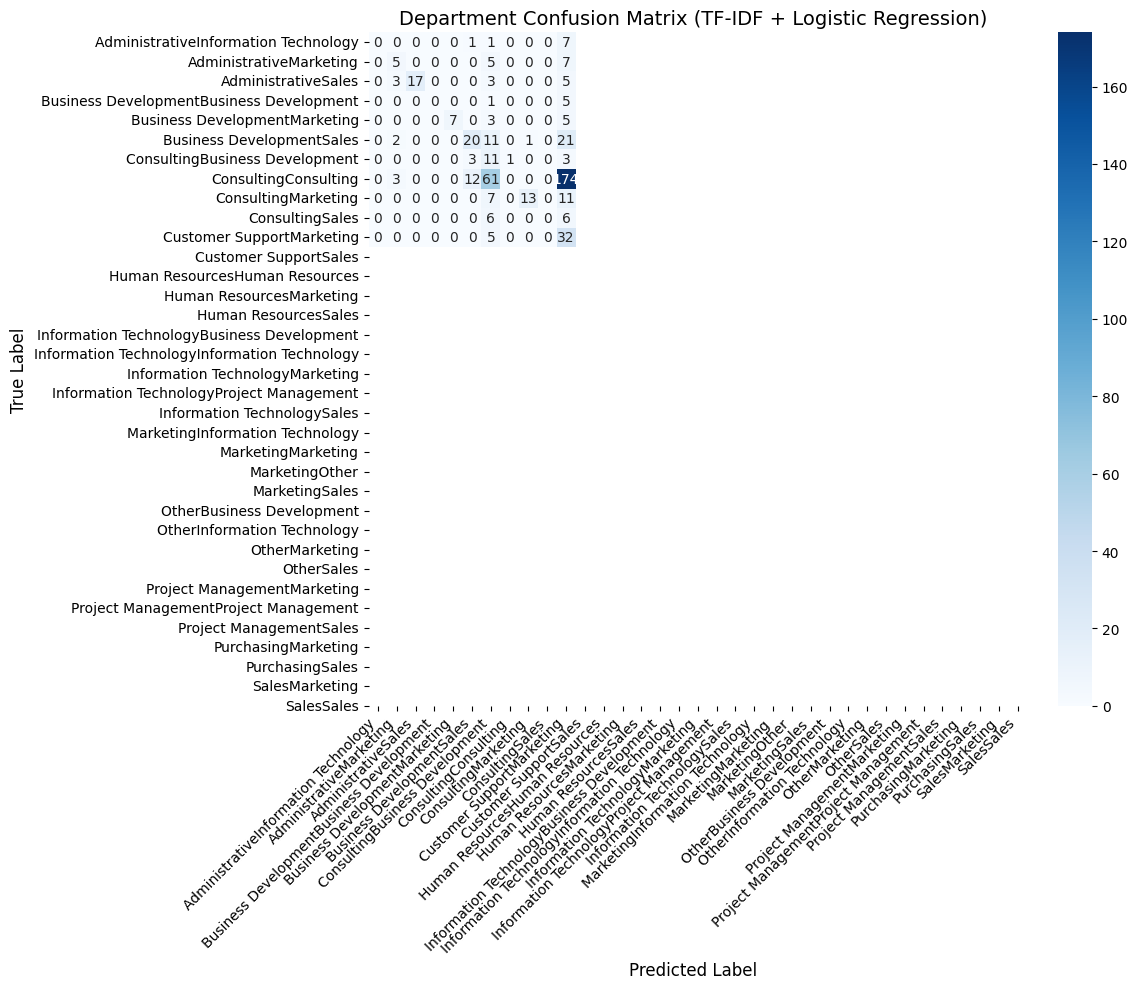

In [18]:
# Department confusion matrix
dept_cm = confusion_matrix(dept_true, dept_predictions)
dept_labels = sorted(set(dept_true + dept_predictions))

plt.figure(figsize=(12, 10))
sns.heatmap(dept_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=dept_labels, yticklabels=dept_labels)
plt.title('Department Confusion Matrix (TF-IDF + Logistic Regression)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

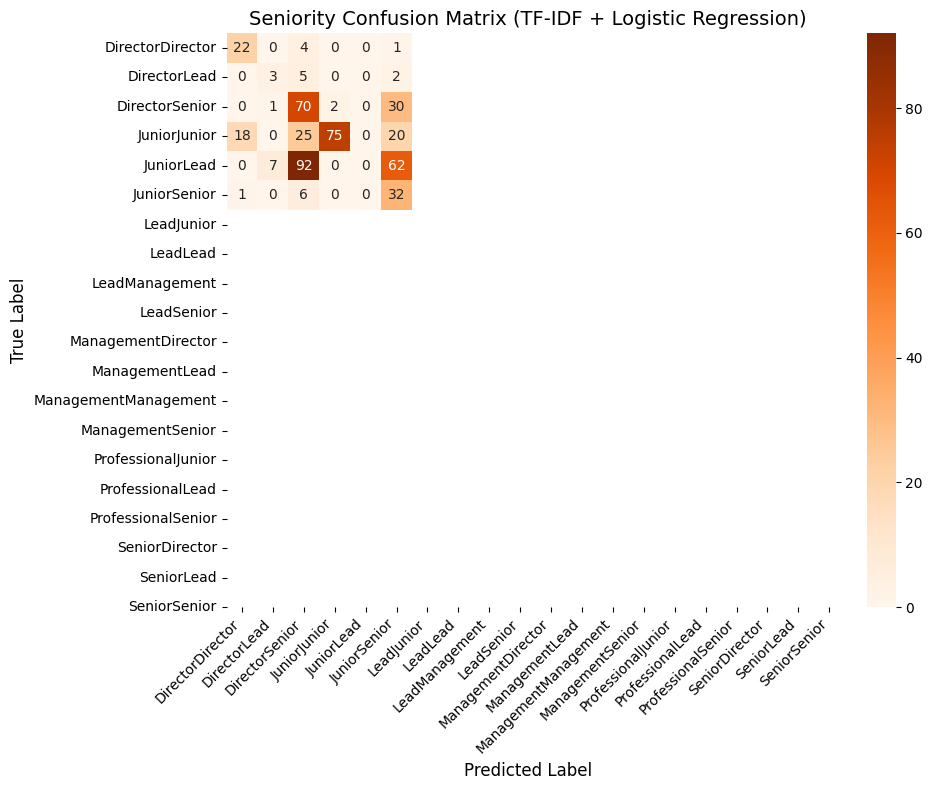

In [19]:
# Seniority confusion matrix
sen_cm = confusion_matrix(sen_true, sen_predictions)
sen_labels = sorted(set(sen_true + sen_predictions))

plt.figure(figsize=(10, 8))
sns.heatmap(sen_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=sen_labels, yticklabels=sen_labels)
plt.title('Seniority Confusion Matrix (TF-IDF + Logistic Regression)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 8. Save Results for Comparison

In [20]:
# Prepare results dictionary
results = {
    "approach": "TF-IDF + Logistic Regression",
    "department": {
        "accuracy": float(dept_accuracy),
        "precision": float(dept_precision),
        "recall": float(dept_recall),
        "f1_macro": float(dept_f1),
        "f1_weighted": float(dept_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in dept_f1_scores.items()}
    },
    "seniority": {
        "accuracy": float(sen_accuracy),
        "precision": float(sen_precision),
        "recall": float(sen_recall),
        "f1_macro": float(sen_f1),
        "f1_weighted": float(sen_weighted_f1),
        "per_class_f1": {k: float(v) for k, v in sen_f1_scores.items()}
    },
    "metadata": {
        "training_samples": len(dept_train_texts) + len(sen_train_texts),
        "dept_train_samples": len(dept_train_texts),
        "dept_vocab_size": len(dept_vectorizer.vocabulary_),
        "sen_train_samples": len(sen_train_texts),
        "sen_vocab_size": len(sen_vectorizer.vocabulary_),
        "max_features": {"department": 5000, "seniority": 3000},
        "ngram_range": "(1, 2)",
        "C": 1.0
    },
    "timestamp": datetime.now().isoformat()
}

# Save to JSON
output_path = RESULTS_DIR / 'tfidf_logreg_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved to: {output_path}")
print(f"\nSummary:")
print(f"  Department - Accuracy: {dept_accuracy:.4f}, F1 (macro): {dept_f1:.4f}")
print(f"  Seniority  - Accuracy: {sen_accuracy:.4f}, F1 (macro): {sen_f1:.4f}")


✅ Results saved to: results\tfidf_logreg_results.json

Summary:
  Department - Accuracy: 0.2197, F1 (macro): 0.2831
  Seniority  - Accuracy: 0.4226, F1 (macro): 0.4056


---

## Summary

### Strengths
- ✅ Highly interpretable (feature importance shows important words)
- ✅ Fast training (<1 minute)
- ✅ Fast inference (milliseconds)
- ✅ Small model size (~1MB vs 250MB for transformers)
- ✅ Works well with limited data
- ✅ No GPU required

### Limitations
- ❌ Bag-of-words assumption (ignores word order)
- ❌ No semantic understanding
- ❌ May struggle with rare word combinations
- ❌ Feature engineering required (n-gram selection)

### Use Cases
- Production deployment (fast, lightweight)
- Debugging and understanding model decisions
- Baseline for more complex models
- Quick experimentation

### Next Steps
- **Notebook 99**: Final comparison of all approaches
- Compare performance: rule-based < embedding < TF-IDF+LR ≈ transformer